## TODO
* `gb_accession` and `gisaid_accession` are not found for new sequences, how do we concat to `metadata.csv` without them?
* metadata format for NCBI
* support tools for manual sanity checks

In [1]:
from bjorn import *
import gffutils

## Sequence Release

In [14]:
df = pd.read_csv("/home/al/analysis/2020-12-01_release_2/metadata.csv")
df.tail()

,ID,gb_accession,gisaid_accession,collection_date,location,percent_coverage_cds,avg_depth,authors,originating_lab
2761,SEARCH-4685-SAN,NaN,NaN,2020-11-02,USA/California/San Diego,100.0000,4831.37,"SEARCH Alliance San Diego with Tracy Basler, J...",San Diego County Public Health Laboratory
2762,SEARCH-4686-SAN,NaN,NaN,2020-11-05,USA/California/San Diego,100.0000,3864.73,"SEARCH Alliance San Diego with Tracy Basler, J...",San Diego County Public Health Laboratory
2763,SEARCH-4687-ORA,NaN,NaN,2020-11-02,USA/California/Orange,98.1400,3123.54,"SEARCH Alliance San Diego with Tracy Basler, J...",San Diego County Public Health Laboratory
2764,SEARCH-4690-SAN,NaN,NaN,2020-05-28,USA/California/San Diego,98.7283,2625.16,"SEARCH Alliance San Diego with Tracy Basler, J...",San Diego County Public Health Laboratory
2765,SEARCH-4691-SAN,NaN,NaN,2020-05-20,USA/California/San Diego,99.1465,2623.45,"SEARCH Alliance San Diego with Tracy Basler, J...",San Diego County Public Health Laboratory


In [10]:
!cat run.sh

#!/bin/bash

python3 bjorn.py --not-dry-run --out-dir /home/al/analysis/2020-12-01_release_2 --sample-sheet /home/al/data/COVID_sequencing_summary-GISAID.csv --cpus 4 --analysis-folder /home/gk/analysis/ --output-metadata /home/al/code/HCoV-19-Genomics/metadata.csv


In [2]:
# path to reference sequence (used later for MSA and tree construction)
ref_path = Path('/home/gk/code/hCoV19/db/NC045512.fasta')
# whether or not to include bam files in the release
include_bams = False
# path to reference sequence (used later for MSA and tree construction)
# this is the directory where results get saved
out_dir = Path('/home/al/data/bjorn_test')
# number of cores to use
num_cpus = 4
# file path to samples sheet (make sure it is the most recent)
sample_sheet_fpath = Path('/home/al/data/COVID_sequencing_summary-GISAID.csv')
# path to analysis results
analysis_fpath = Path('/home/gk/analysis/')
# file path to metadata of samples that have already been released
released_samples_fpath = Path('/home/al/code/HCoV-19-Genomics/metadata.csv')
# Whether run is dry
dry_run = False
# COLUMNS TO INCLUDE IN METADATA
git_meta_cols = ["ID", "collection_date", "location", 
                 "percent_coverage_cds", "avg_depth", 
                 "authors", "originating_lab"]
gisaid_meta_cols = ['Submitter',
                   'FASTA filename', 'Virus name', 'Type', 'Passage details/history',
                   'Collection date', 'location', 'Additional location information',
                   'Host', 'Additional host information', 'Gender', 'Patient age',
                   'Patient status', 'Specimen source', 'Outbreak', 'Last vaccinated',
                   'Treatment', 'Sequencing technology', 'Assembly method', 'Coverage',
                   'originating_lab', 'Address', 'Sample ID given by the sample provider',
                   'Submitting lab', 'Address.1',
                   'Sample ID given by the submitting laboratory', 'authors', 'avg_depth']

In [3]:



# # Test
# out_dir = "/home/gk/southpark/2020-11-21_release"
# sample_sheet_fpath = "/home/gk/code/hCoV19/release_summary_csv/2020-11-20_seq_summary.csv"
# analysis_fpath = "/home/gk/analysis/"
# released_samples_fpath = "/home/gk/analysis/hcov-19-genomics/metadata.csv"
# dry_run = True

print(f"""
Dry run: {dry_run}.
Include BAMS: {include_bams}.
Reading release summary file from {sample_sheet_fpath}.
Reading repository metadata from {released_samples_fpath}.
Searching analysis folder {analysis_fpath}.
"""
)

# Collecting Sequence Data


# grab all filepaths for bam data
bam_filepaths = glob.glob(f"{analysis_fpath}/**/merged_aligned_bams/illumina/*.bam")
bam_filepaths = [Path(fp) for fp in bam_filepaths]
# consolidate sample ID format
bam_ids = get_ids(bam_filepaths)
# Turn into dataframe
bam_data = list(zip(*[bam_ids, bam_filepaths]))
bam_df = pd.DataFrame(data=bam_data, columns=['sample_id', 'PATH'])
# grab all paths to consensus sequences
consensus_filepaths = glob.glob(f"{analysis_fpath}/**/consensus_sequences/illumina/*.fa")
consensus_filepaths = [Path(fp) for fp in consensus_filepaths]
# consolidate sample ID format
consensus_ids = get_ids(consensus_filepaths)
# Turn into dataframe
consensus_data = list(zip(*[consensus_ids, consensus_filepaths]))
consensus_df = pd.DataFrame(data=consensus_data, columns=['sample_id', 'PATH'])
# clean up cns and bam (remove duplicate IDs)
bam_df.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
consensus_df.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
# include only SEARCH samples
consensus_df = consensus_df[(consensus_df['sample_id'].str.contains('SEARCH'))]
# merge consensus and bam filepaths for each sample ID
analysis_df = pd.merge(consensus_df, bam_df, on='sample_id', how='left')
# load sample sheet data (GISAID) - make sure to download most recent one
seqsum = pd.read_csv(sample_sheet_fpath)
# clean up
seqsum = seqsum[(~seqsum['SEARCH SampleID'].isna()) & (seqsum['SEARCH SampleID']!='#REF!')]
# consolidate sample ID format
seqsum.loc[:, 'sample_id'] = seqsum['SEARCH SampleID'].apply(process_id)
seqsum.drop_duplicates(subset=['sample_id'], keep='last', inplace=True)
seqsum = seqsum[seqsum['New sequences ready for release'] == 'Yes']
num_seqs_to_release = seqsum['sample_id'].unique().shape[0]
# JOIN summary sheet with analysis meta data
sequence_results = pd.merge(seqsum, analysis_df, on='sample_id', how='inner')
# compute number of samples with missing consensus and/or bam files
num_seqs_found = sequence_results['sample_id'].unique().shape[0]
num_samples_missing_cons = num_seqs_to_release - num_seqs_found
num_samples_missing_bams = 'NA'
if include_bams:
    # exclude any samples that do not have BAM data
    num_samples_missing_bams = sequence_results[sequence_results['PATH_y'].isna()].shape[0]
    sequence_results = sequence_results[~sequence_results['PATH_y'].isna()]
# samples missing consensus or BAM sequence files
# ## Make sure to remove any samples that have already been uploaded to github (just an extra safety step)
# load metadata.csv from github repo, then clean up
meta_df = pd.read_csv(released_samples_fpath)
meta_df = meta_df[meta_df['ID'].str.contains('SEARCH')]
# consolidate sample ID format
meta_df.loc[:, 'sample_id'] = meta_df['ID'].apply(process_id)
# get IDs of samples that have already been released
released_seqs = meta_df['sample_id'].unique()
# filter out released samples from all the samples we got
final_result = sequence_results.copy()
# final_result = sequence_results[~sequence_results['sample_id'].isin(released_seqs)]
print(f"Preparing {final_result.shape[0]} samples for release")
# Transfer files
if not dry_run:
    transfer_files(final_result, out_dir, include_bams=include_bams, ncpus=num_cpus)
# ## Getting coverage information
cov_filepaths = glob.glob(f"{analysis_fpath}/**/trimmed_bams/illumina/reports/*.tsv")
cov_filepaths = [Path(fp) for fp in cov_filepaths]
# read coverage data and clean it up
cov_df = pd.concat((pd.read_csv(f, sep='\t').assign(path=f) for f in cov_filepaths))
cov_df.loc[:,'sample_id'] = cov_df['SAMPLE'].apply(process_coverage_sample_ids)
cov_df.loc[:,'date'] = cov_df['path'].apply(lambda x: ''.join(x.split('/')[4].split('.')[:3]))
cov_df = (cov_df.sort_values('date')
                .drop_duplicates(subset=['sample_id'], keep='last'))


Dry run: False.
Include BAMS: False.
Reading release summary file from /home/al/data/COVID_sequencing_summary-GISAID.csv.
Reading repository metadata from /home/al/code/HCoV-19-Genomics/metadata.csv.
Searching analysis folder /home/gk/analysis/.

Preparing 366 samples for release
Transferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4099_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4099_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4181_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4181_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4140_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4140_L001_L002_L003_L004.fa


Transferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4102_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4102_L001_L002_L003_L004.faTra

Transferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4253_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4253_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4176_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4176_L001_L002_L003_L004.fa
Transferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4249_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4249_L001_L002_L003_L004.fa
Transferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4211_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4211_L001_L002_L003_L004.fa
Transferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4254_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4254_L001_L002_L003_L004.fa

Transferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4177_L001_L002_L003_

Transferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4303_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4303_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.16.hCoV19/consensus_sequences/illumina/SEARCH-4384_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4384_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.16.hCoV19/consensus_sequences/illumina/SEARCH-4398_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4398_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4340_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4340_L001_L002_L003_L004.fa



Transferring /home/gk/analysis/2020.11.16.hCoV19/consensus_sequences/illumina/SEARCH-4385_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4385_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.11.hCoV19/consensus_sequences/illumina/SEARCH-4304_L001_L002_L003_L

Transferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4530_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4530_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4497_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4497_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.16.hCoV19/consensus_sequences/illumina/SEARCH-4462_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4462_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4543_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4543_L001_L002_L003_L004.fa



Transferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4531_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4531_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4498_L001_L002_L003_L

Transferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4649_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4649_L001_L002_L003_L004.fa

Transferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4682_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4682_L001_L002_L003_L004.fa
Transferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4650_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4650_L001_L002_L003_L004.faTransferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4613_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4613_L001_L002_L003_L004.fa
Transferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4683_L001_L002_L003_L004.fa to /home/al/data/bjorn_test/fa/SEARCH-4683_L001_L002_L003_L004.fa

Transferring /home/gk/analysis/2020.11.25.hCoV19/consensus_sequences/illumina/SEARCH-4651_L001_L002_L003

In [4]:
# ans.columns

In [5]:
# JOIN results with coverage info
ans = (
    pd.merge(final_result, cov_df, on='sample_id', how='left')
    .assign(
        collection_date = lambda x: pd.to_datetime(x["Collection date"]).dt.strftime("%Y-%m-%d")
    )
    .rename(columns={
        "SEARCH SampleID": "ID",
        "Location": "location",
        "COVERAGE": "percent_coverage_cds",
        "AVG_DEPTH": "avg_depth",
        "Authors": "authors",
        "Originating lab": "originating_lab"
    })
)
num_samples_missing_coverage = ans[ans['percent_coverage_cds'].isna()].shape[0]

def create_github_meta(new_meta_df: pd.DataFrame, old_meta_filepath: str, meta_cols: list):
    """Generate Github metadata with updated information about newly released samples"""
    old_metadata = pd.read_csv(old_meta_filepath)
    new_metadata = pd.concat([old_metadata, new_meta_df.loc[:, meta_cols]])
    new_metadata.to_csv(out_dir/'metadata.csv', index=False)
    return f"Github metadata saved in {out_dir/'metadata.csv'}"

def create_gisaid_meta(new_meta_df: pd.DataFrame, meta_cols: list):
    """Generate GISAID metadata for newly released samples"""
    new_meta_df[meta_cols].to_csv(out_dir/'gisaid_metadata.csv', index=False)
    return f"GISAID metadata saved in {out_dir/'gisaid_metadata.csv'}"

create_github_meta(ans, released_samples_fpath, git_meta_cols)
create_gisaid_meta(ans, gisaid_meta_cols) 
low_coverage_samples = ans[ans["percent_coverage_cds"] < 90]
# Data logging
with open("{}/data_release.log".format(out_dir), 'w') as f:
    f.write(f'{num_samples_missing_coverage} samples are missing coverage information\n')
    f.write(f'{low_coverage_samples.shape[0]} samples were found to have coverage below 90%\n')
    f.write(f'{num_samples_missing_cons} samples were ignored because they were missing consensus sequence files\n')
    f.write(f'{num_samples_missing_bams} samples were ignored because they were missing BAM sequence files\n')
print(f"Transfer Complete. All results saved in {out_dir}")

Transfer Complete. All results saved in /home/al/data/bjorn_test


In [6]:
num_samples_missing_coverage

243

In [7]:
ans.columns

Index(['Sample ID', 'ID', 'Ready for release?',
       'New sequences ready for release', 'Released?', 'Submitter',
       'FASTA filename', 'Virus name', 'Type', 'Passage details/history',
       'Collection date', 'location', 'Additional location information',
       'Host', 'Additional host information', 'Gender', 'Patient age',
       'Patient status', 'Specimen source', 'Outbreak', 'Last vaccinated',
       'Treatment', 'Sequencing technology', 'Assembly method', 'Coverage',
       'originating_lab', 'Address', 'Sample ID given by the sample provider',
       'Submitting lab', 'Address.1',
       'Sample ID given by the submitting laboratory', 'authors', 'Comment',
       'Comment Icon', 'sample_id', 'PATH_x', 'PATH_y', 'SAMPLE',
       'percent_coverage_cds', 'avg_depth', 'MIN', 'MAX', 'ZERO_DEPTH', 'path',
       'date', 'collection_date'],
      dtype='object')

## Genbank

## renaming fasta headers

In [8]:
cons_seqs = Path(out_dir/'fa')

In [9]:
sampleid2name = pd.Series(ans['Virus name'].values,index=ans['sample_id']).to_dict()

## multiple sequence alignment

In [10]:
msa_dir = out_dir/'msa'
if not Path.isdir(msa_dir):
    Path.mkdir(msa_dir);

In [11]:
cons_seqs = Path(out_dir/'fa')
copy(ref_path, cons_seqs)

Path('/home/al/data/bjorn_test/fa/NC045512.fasta')

In [12]:
out_dir.basename()

Path('bjorn_test')

In [32]:
cat_cmd = f"cat {out_dir}/fa/*.fa > {msa_dir/out_dir.basename()}.fa"
subprocess.check_call(cat_cmd, shell=True)

0

In [33]:
msa_cmd = f"mafft --auto --thread {num_cpus} {msa_dir/out_dir.basename()}.fa > {msa_dir/out_dir.basename()}_aligned.fa"
subprocess.check_call(msa_cmd, shell=True)

0

In [34]:
ans

,Sample ID,ID,Ready for release?,New sequences ready for release,Released?,Submitter,FASTA filename,Virus name,Type,Passage details/history,...,PATH_y,SAMPLE,percent_coverage_cds,avg_depth,MIN,MAX,ZERO_DEPTH,path,date,collection_date
0,21-001427-01,SEARCH-4099-SAN,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-4099-SAN/2020,betacoronavirus,Original,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-01
1,21-003400-01,SEARCH-4102-SAN,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-4102-SAN/2020,betacoronavirus,Original,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-02
2,21-003399-01,SEARCH-4103-SAN,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-4103-SAN/2020,betacoronavirus,Original,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-02
3,21-011067-01,SEARCH-4104-SAN,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-4104-SAN/2020,betacoronavirus,Original,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-08
4,21-002523-01,SEARCH-4106-SAN,Yes,Yes,No,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-4106-SAN/2020,betacoronavirus,Original,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,21-115613-01,SEARCH-4685-SAN,Yes,Yes,NaN,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-4685-SAN/2020,betacoronavirus,Original,...,/home/gk/analysis/2020.11.25.hCoV19/merged_ali...,SEARCH-4685_L001_L002_L003_L004.trimmed.sorted...,100.0000,4831.37,49.0,8001.0,0.0,/home/gk/analysis/2020.11.25.hCoV19/trimmed_ba...,20201125,2020-11-02
362,21-120319-01,SEARCH-4686-SAN,Yes,Yes,NaN,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-4686-SAN/2020,betacoronavirus,Original,...,/home/gk/analysis/2020.11.25.hCoV19/merged_ali...,SEARCH-4686_L001_L002_L003_L004.trimmed.sorted...,100.0000,3864.73,27.0,8005.0,0.0,/home/gk/analysis/2020.11.25.hCoV19/trimmed_ba...,20201125,2020-11-05
363,21-115587-01,SEARCH-4687-ORA,Yes,Yes,NaN,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-4687-ORA/2020,betacoronavirus,Original,...,/home/gk/analysis/2020.11.25.hCoV19/merged_ali...,SEARCH-4687_L001_L002_L003_L004.trimmed.sorted...,98.1400,3123.54,0.0,8017.0,82.0,/home/gk/analysis/2020.11.25.hCoV19/trimmed_ba...,20201125,2020-11-02
364,20-062452,SEARCH-4690-SAN,Yes,Yes,NaN,Karthik Gangavarapu,NaN,hCoV-19/USA/SEARCH-4690-SAN/2020,betacoronavirus,Original,...,/home/gk/analysis/2020.11.25.hCoV19/merged_ali...,SEARCH-4690_L001_L002_L003_L004.trimmed.sorted...,98.7283,2625.16,0.0,8008.0,5.0,/home/gk/analysis/2020.11.25.hCoV19/trimmed_ba...,20201125,2020-05-28


In [ ]:
seq = SeqIO.parse(f"{msa_dir/out_dir.basename()}.fa", "fasta")
seqs = list(seq)

metadata = pd.read_csv(f"{out_dir}/gisaid_metadata.csv")

sum_seqs = 0
for ctr, (n, grp) in enumerate(metadata.groupby("authors")):
    print(f"{ctr}: {n}")
    tmpl = pd.read_csv(f"{out_dir}/source_modifiers.tsv", sep="\t")
    tmpl["ID"] = tmpl["Sequence_ID"].apply(lambda x: x.split("/")[2])
    grp = grp.rename(columns = {
        "location": "country",
        "collection_date": "collection-date"
    })
    merged_tmpl = pd.merge(tmpl.loc[:, ["Sequence_ID", "isolate", "ID"]], grp, on="ID")
    sum_seqs += merged_tmpl.shape[0]
    if merged_tmpl.shape[0] == 0:
        continue
    merged_tmpl = merged_tmpl[["Sequence_ID", "isolate", "country", "collection-date"]]
    merged_tmpl["country"] = merged_tmpl["country"].apply(lambda x: x.split("/")[0])
    merged_tmpl["host"] = "Homo Sapiens"
    merged_tmpl["isolate"] = merged_tmpl["isolate"].str.replace("hCoV-19", "SARS-CoV-2/human")
    merged_tmpl["isolation-source"] = "Nasopharyngeal swab"
    merged_tmpl.loc[merged_tmpl["country"] == "MEX", "country"] = "Mexico"
    merged_tmpl.to_csv(f"{out_dir}/gb_fasta/genbank_metadata_{ctr}.tsv", sep="\t", index=False)
    recs = [i for i in seqs if i.name in merged_tmpl["Sequence_ID"].tolist()]
    SeqIO.write(recs, f"{out_dir}/gb_fasta/genbank_release_{ctr}.fa", "fasta")

## JSON metadata for CViSB portal

In [ ]:
# datadownload.json
{"includedInDataset": "sarscov2-virus-seq", "identifier": "SEARCH-0289-NBG.fa", 
 "name": "SEARCH-0289-NBG.fa", 
 "contentUrl": "https://console.cloud.google.com/storage/browser/_details/andersen-lab_hcov-19-genomics/consensus_sequences/SEARCH-0289-NBG.fa", 
 "additionalType": "raw data", "variableMeasured": ["SARS-CoV-2 virus sequence"], 
 "measurementTechnique": ["Nucleic Acid Sequencing"], 
 "dateModified": "2020-11-16", "experimentIDs": ["SEARCH-0289-NBG-sarscov2"]}

In [ ]:
# patient.json
{"patientID": "SEARCH-0289-NBG", 
 "dateModified": "2020-11-16", 
 "cohort": "COVID-19", 
 "outcome": "unknown", 
 "alternateIdentifier": ["SEARCH-0289-NBG"], 
 "infectionYear": 2020, 
 "publisher": {"@type": "Organization", 
               "identifier": "CViSB", 
               "url": "https://cvisb.org/", 
               "name": "Center for Viral Systems Biology", 
               "contactPoint": {"@type": "ContactPoint", "contactType": "technical support", 
                                "url": "https://cvisb.org/", "email": "info@cvisb.org"}}, 
 "citation": [{"name": "Allison Smither, Gilberto Sabino-Santos, Patricia Snarski, Lilia Melnik, Antoinette Bell, Kaylynn Genemaras, Arnaud Drouin, Dahlene Fusco, Robert Garry with SEARCH Alliance San Diego", "@type": "Organization"}],
 "updatedBy": "Julia Mullen", 
 "country": {"@type": "Country", "name": "United States", "administrativeUnit": 0, "administrativeType": "country", "identifier": "US", "url": "https://www.iso.org/obp/ui/#iso:code:3166:US"}, "presentationDate": "2020-03-31", 
 "presentationWeek": {"gt": "2020-03-30", "lt": "2020-04-06"}},

In [ ]:
# experiment.json
{"experimentID": "MG0987-sarscov2", 
 "privatePatientID": "MG0987", 
 "variableMeasured": "SARS-CoV-2 virus sequence", 
 "measurementTechnique": "Nucleic Acid Sequencing", 
 "includedInDataset": "sarscov2-virus-seq", 
 "dateModified": "2020-11-16", 
 "citation": [{"name": "SEARCH Alliance San Diego", 
               "@type": "Organization"}], 
 "data": [{"@type": "VirusSeqData", "virus": "SARS-CoV-2", 
           "virusSegment": null, "DNAsequence": "NNN"}]}

In [48]:
def to_json_entry(x):
    """Return experiment metadata in JSON format compatible with CViSB Data Portal"""
    patient_id = x['ID']
    date = x['collection_date']
    authors = x['authors']
    return {"experimentID": f"{patient_id}-sarscov2", "privatePatientID": patient_id, 
           "variableMeasured": "SARS-CoV-2 virus sequence", 
           "measurementTechnique": "Nucleic Acid Sequencing", 
           "includedInDataset": "sarscov2-virus-seq", 
           "dateModified": date, 
           "citation": [{"name": authors, 
                         "@type": "Organization"}], "data": []}

ans.apply(to_json_entry, axis=1).tolist()

[{'experimentID': 'MG0987-sarscov2',
  'privatePatientID': 'MG0987',
  'variableMeasured': 'SARS-CoV-2 virus sequence',
  'measurementTechnique': 'Nucleic Acid Sequencing',
  'includedInDataset': 'sarscov2-virus-seq',
  'dateModified': '2020-03-18',
  'citation': [{'name': 'SEARCH Alliance San Diego', '@type': 'Organization'}],
  'data': []},
 {'experimentID': 'PC00101P-sarscov2',
  'privatePatientID': 'PC00101P',
  'variableMeasured': 'SARS-CoV-2 virus sequence',
  'measurementTechnique': 'Nucleic Acid Sequencing',
  'includedInDataset': 'sarscov2-virus-seq',
  'dateModified': '2020-03-11',
  'citation': [{'name': 'SEARCH Alliance San Diego', '@type': 'Organization'}],
  'data': []},
 {'experimentID': 'SEARCH-0007-SAN-sarscov2',
  'privatePatientID': 'SEARCH-0007-SAN',
  'variableMeasured': 'SARS-CoV-2 virus sequence',
  'measurementTechnique': 'Nucleic Acid Sequencing',
  'includedInDataset': 'sarscov2-virus-seq',
  'dateModified': '2020-03-21',
  'citation': [{'name': 'SEARCH Allian

## NCBI metadata

## iSNV Analysis

In [2]:
cols = ['sample', 'GFF_FEATURE', 'POS', 'REF', 'ALT', 'ALT_FREQ']

In [5]:
sample_ids = [4531, 4690, 4691]
v_fps = get_variant_filepaths(sample_ids)
v_df = get_variant_data(v_fps)[cols]
v_df.drop_duplicates(subset=['sample', 'POS', 'ALT'], inplace=True)

In [6]:
v_fps

{4531: '/home/gk/analysis/2020.11.25.hCoV19/variants/illumina/SEARCH-4531_L001_L002_L003_L004.tsv',
 4690: '/home/gk/analysis/2020.11.25.hCoV19/variants/illumina/SEARCH-4690_L001_L002_L003_L004.tsv',
 4691: '/home/gk/analysis/2020.11.25.hCoV19/variants/illumina/SEARCH-4691_L001_L002_L003_L004.tsv'}

In [7]:
v_df[v_df['POS']==12369]

,sample,GFF_FEATURE,POS,REF,ALT,ALT_FREQ
9,4531,cds-YP_009724389.1,12369,C,T,1.000000
27,4690,cds-YP_009724389.1,12369,C,T,0.976622


In [8]:
v_df.loc[(v_df['REF']=='C')&(v_df['ALT']=='T')&(v_df['POS'] > 12300)&(v_df['POS'] < 12400)][['sample', 'POS', 'REF', 'ALT', 'ALT_FREQ']]

,sample,POS,REF,ALT,ALT_FREQ
9,4531,12369,C,T,1.000000
27,4690,12369,C,T,0.976622


In [7]:
ans = v_df.loc[(v_df.duplicated(subset=['POS'], keep=False))][['sample', 'POS', 'REF', 'ALT', 'ALT_FREQ']].sort_values('POS')


In [8]:
v_df['var'] = v_df['POS'].astype(str) + ':' + v_df['ALT']
v_df[v_df['ALT_FREQ'] < 0.5].groupby('sample').agg(num_minor_vars=('var', 'nunique'))

,num_minor_vars
sample,
4531,6
4690,33
4691,14


In [9]:
v_df.loc[(v_df['sample']==4531)&(v_df['ALT_FREQ']<0.5)][cols]

,sample,GFF_FEATURE,POS,REF,ALT,ALT_FREQ
5,4531,NaN,1601,C,-TTA,0.045389
8,4531,NaN,6696,C,+T,0.041880
11,4531,cds-YP_009724389.1,13940,A,G,0.057012
19,4531,cds-YP_009724390.1,22165,T,C,0.030303
22,4531,NaN,22583,G,+T,0.092683
27,4531,cds-YP_009724390.1,24072,A,G,0.039066


In [10]:
v_df.loc[v_df['POS']==29348][cols]

,sample,GFF_FEATURE,POS,REF,ALT,ALT_FREQ
58,4690,cds-YP_009724397.2,29348,G,T,0.522132


In [11]:
v_df[(v_df['REF']=='G')&(v_df['ALT']=='T')][cols]

,sample,GFF_FEATURE,POS,REF,ALT,ALT_FREQ
21,4531,cds-YP_009724390.1,22343,G,T,1.000000
28,4531,cds-YP_009724391.1,25563,G,T,1.000000
29,4531,cds-YP_009724397.2,28899,G,T,0.999853
15,4690,cds-YP_009724389.1,4806,G,T,0.047414
50,4690,cds-YP_009724391.1,25563,G,T,1.000000
58,4690,cds-YP_009724397.2,29348,G,T,0.522132
9,4691,cds-YP_009724389.1,7805,G,T,0.032258
22,4691,cds-YP_009724390.1,22775,G,T,0.032258
26,4691,cds-YP_009724391.1,25563,G,T,1.000000


In [12]:
ans.to_excel('common_variants.xlsx', index=False)

In [18]:
var_fps = glob.glob(f"/home/gk/analysis/**/variants/illumina/*.tsv")
var_df = (pd.concat((pd.read_csv(f, sep='\t') for f in var_fps)))
print(var_df.shape)
var_df.head()

(140796, 40)


,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,...,REF_RV_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,REF_QUAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_DP_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_RV_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_QUAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_FREQ_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,TOTAL_DP_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,PVAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,PASS_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,Unnamed: 29
0,NC_045512.2,241,C,T,1.0,0.0,72.0,3314.0,769.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NC_045512.2,1884,C,T,1541.0,1085.0,39.0,66.0,35.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NC_045512.2,1884,C,T,1541.0,1085.0,39.0,66.0,35.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC_045512.2,2455,C,T,0.0,0.0,0.0,371.0,227.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_045512.2,2455,C,T,0.0,0.0,0.0,371.0,227.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
gff_filepath = '/home/al/data/hcov19/gff/NC_045512.2.gff3'
fn = gffutils.example_filename(gff_filepath)
db = gffutils.create_db(fn, dbfn='test.db', merge_strategy='merge', force=True)
all_gffs = var_df['GFF_FEATURE'].dropna().unique()
gff2gene = {}
for gff in all_gffs:
    if gff:
        gff2gene[gff] = db[gff]['gene'][0]
gff2gene

{'cds-YP_009724389.1': 'ORF1ab',
 'cds-YP_009725295.1': 'ORF1ab',
 'cds-YP_009724390.1': 'S',
 'cds-YP_009724396.1': 'ORF8',
 'cds-YP_009724397.2': 'N',
 'cds-YP_009724395.1': 'ORF7a',
 'cds-YP_009724391.1': 'ORF3a',
 'cds-YP_009724393.1': 'M',
 'cds-YP_009724394.1': 'ORF6',
 'cds-YP_009725255.1': 'ORF10',
 'cds-YP_009725318.1': 'ORF7b',
 'cds-YP_009724392.1': 'E'}

In [20]:
var_df['gene'] = var_df['GFF_FEATURE'].apply(lambda x: gff2gene.get(x, 'nan'))

In [24]:
var_df.drop(columns=['GFF_FEATURE'], inplace=True)
try:
    var_df['gene'] = var_df['GFF_FEATURE'].apply(lambda x: gff2gene.get(x, 'nan'))
except:
    raise KeyError('GFF_FEATURE column not found in the input dataframe.')

KeyError: 'GFF_FEATURE column not found in the input dataframe.'

In [21]:
var_df.loc[var_df['gene']=='nan']

,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,...,REF_QUAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_DP_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_RV_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_QUAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_FREQ_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,TOTAL_DP_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,PVAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,PASS_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,Unnamed: 29,gene
0,NC_045512.2,241,C,T,1.0,0.0,72.0,3314.0,769.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
7,NC_045512.2,11074,C,+T,7363.0,1334.0,37.0,457.0,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
8,NC_045512.2,11082,T,-G,6809.0,1324.0,36.0,650.0,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
21,NC_045512.2,27689,C,+A,50.0,15.0,43.0,7.0,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
22,NC_045512.2,27697,C,-T,50.0,16.0,43.0,2.0,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,NC_045512.2,10527,C,+T,2717.0,291.0,43.0,125.0,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
15,NC_045512.2,11074,C,+T,12448.0,2356.0,41.0,709.0,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
17,NC_045512.2,14327,C,+A,133367.0,10771.0,43.0,5997.0,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
21,NC_045512.2,21372,G,+T,243.0,128.0,37.0,40.0,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan


In [22]:
var_df.loc[var_df['gene']=='nan', 'gene'] = var_df.loc[var_df['gene']=='nan', 'POS'].apply(map_gene_to_pos)
var_df.loc[var_df['gene']=='nan']

,REGION,POS,REF,ALT,REF_DP,REF_RV,REF_QUAL,ALT_DP,ALT_RV,ALT_QUAL,...,REF_QUAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_DP_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_RV_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_QUAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,ALT_FREQ_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,TOTAL_DP_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,PVAL_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,PASS_54idSEARCH0513SAN_L001_L002_L003_L004.tsv,Unnamed: 29,gene
0,NC_045512.2,241,C,T,1.0,0.0,72.0,3314.0,769.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
30,NC_045512.2,29703,G,T,30.0,22.0,44.0,1.0,1.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
31,NC_045512.2,29764,G,T,0.0,0.0,0.0,22.0,18.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
32,NC_045512.2,29784,C,T,15.0,12.0,43.0,1.0,1.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
0,NC_045512.2,241,C,T,4.0,2.0,35.0,5243.0,901.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,NC_045512.2,241,C,T,0.0,0.0,0.0,1077.0,221.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
0,NC_045512.2,241,C,T,0.0,0.0,0.0,540.0,94.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
0,NC_045512.2,241,C,T,1.0,0.0,36.0,4409.0,258.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
15,NC_045512.2,29725,A,-T,406.0,150.0,37.0,45.0,0.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan


In [16]:
def map_gene_to_pos(x):
    pos = x
    if pos >= 269 and pos <= 21555:
        return 'ORF1ab'
    elif pos >= 21564 and pos <= 25382:
        return 'S'
    elif pos >= 25410 and pos <= 26214:
        return 'ORF3a'
    elif pos >= 26247 and pos <= 26471:
        return 'E'
    elif pos >= 26523 and pos <= 27187:
        return 'M'
    elif pos >= 27203 and pos <= 27382:
        return 'ORF6'
    elif pos >= 27398 and pos <= 27754:
        return 'ORF7a'
    elif pos >= 27757 and pos <= 27887:
        return 'ORF7b'
    elif pos >= 27896 and pos <= 28257:
        return 'ORF8'
    elif pos >= 28289 and pos <= 29528:
        return 'N'
    elif pos >= 29564 and pos <= 29670:
        return 'ORF10'
    return 'nan'
# v_df = v_df.apply(map_gene_to_pos, axis=1)

In [57]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [76]:
colors = list(mcolors.TABLEAU_COLORS.keys())
len(colors)

10

In [77]:
colors = colors + ['black']

In [78]:
colors

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan',
 'black']

In [79]:
v_df['gene'].unique()

array(['nan', 'ORF1ab', 'S', 'ORF3a', 'N', 'M', 'ORF7b', 'E'],
      dtype=object)

In [80]:
genes = ['ORF1ab', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a',
         'ORF7b', 'ORF8', 'N', 'ORF10']

In [81]:
gene2color = {}
for i, g in enumerate(genes):
    gene2color[g] = colors[i]

In [82]:
v_df['color'] = v_df['gene'].apply(lambda x: gene2color.get(x, 'tab:white'))
v_df

,sample,GFF_FEATURE,POS,REF,ALT,ALT_FREQ,var,gene,color
0,4531,NaN,241,C,T,1.000000,241:T,nan,tab:white
1,4531,cds-YP_009724389.1,1059,C,T,1.000000,1059:T,ORF1ab,tab:blue
3,4531,cds-YP_009724389.1,1102,C,T,1.000000,1102:T,ORF1ab,tab:blue
5,4531,NaN,1601,C,-TTA,0.045389,1601:-TTA,ORF1ab,tab:blue
6,4531,cds-YP_009724389.1,3037,C,T,1.000000,3037:T,ORF1ab,tab:blue
...,...,...,...,...,...,...,...,...,...
25,4691,cds-YP_009724390.1,23403,A,G,0.999815,23403:G,S,tab:orange
26,4691,cds-YP_009724391.1,25563,G,T,1.000000,25563:T,ORF3a,tab:green
27,4691,cds-YP_009724392.1,26300,T,C,0.083333,26300:C,E,tab:red
28,4691,NaN,28969,C,-A,0.034876,28969:-A,N,tab:cyan


In [83]:
gene2color

{'ORF1ab': 'tab:blue',
 'S': 'tab:orange',
 'ORF3a': 'tab:green',
 'E': 'tab:red',
 'M': 'tab:purple',
 'ORF6': 'tab:brown',
 'ORF7a': 'tab:pink',
 'ORF7b': 'tab:gray',
 'ORF8': 'tab:olive',
 'N': 'tab:cyan',
 'ORF10': 'black'}

In [84]:
def get_color_legends(del2color: dict) -> list:
    legend_elements = [Line2D([0], [0], marker='o', color=x, label=y,
                       markerfacecolor=x, markersize=15) for y, x in del2color.items()]
    return legend_elements
legend = get_color_legends(gene2color)
legend

In [85]:
plt.rcParams["figure.figsize"] = (15,15)

In [89]:
s[['POS', 'ALT_FREQ']].values.tolist()

[[3545.0, 0.030302999999999997],
 [6696.0, 0.035313],
 [7735.0, 0.0740741],
 [7805.0, 0.0322581],
 [7930.0, 0.043478300000000004],
 [7953.0, 0.0625],
 [11074.0, 0.034832199999999994],
 [22000.0, 0.04],
 [22120.0, 0.04],
 [22775.0, 0.0322581],
 [22776.0, 0.0322581],
 [26300.0, 0.08333330000000001],
 [28969.0, 0.034876300000000006]]

In [93]:
import seaborn as sns
samples = v_df['sample'].unique()
for s_id in samples:
    s = v_df.loc[(v_df['sample']==s_id)&(v_df['ALT_FREQ']<0.5)&(v_df['gene']!='nan')]
    # I load the seaborn library only to benefit the nice looking feature
    plt.vlines(x=s['POS'], ymin=0, ymax=s['ALT_FREQ'], color=s['color'], alpha=0.4)
    plt.scatter(s['POS'], s['ALT_FREQ'], color=s['color'], s=50, alpha=1)
    for x in s[['POS', 'ALT_FREQ']].values.tolist():
        plt.text(x[0], x[1]+0.001, f"{int(x[0])}", ha='center')
    plt.legend(handles=legend, loc='upper right')
    plt.xlabel('POS')
    plt.ylabel('ALT_FREQ')
    plt.title(f'Minor Variants of Sample {s_id}')
    plt.savefig(f'{s_id}_minor_variants.png')
    plt.clf()

<Figure size 1080x1080 with 0 Axes>

In [97]:
v_df[v_df['ALT_FREQ']<0.5].sort_values('POS').to_excel('minor_variants.xlsx', index=False)

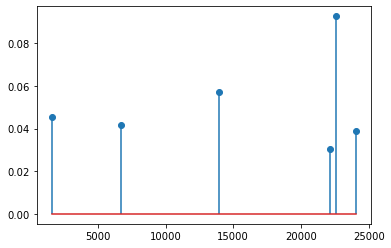

In [30]:
my_range=range(1,len(s.index)+1)
 
# Make the plot
plt.stem(s['POS'], s['ALT_FREQ'], label=s['gene'])
plt.show()
